# Text Detection

Detect Text Labels in OAAM Functions Layer and generally in block-diagrams. Outputs bounding boxes and texts. 

In [74]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pytesseract
from pytesseract import Output
import pandas as pd
import pprint

## Input

In [75]:
# Define the paths
# target_image_path = 'many_tasks.png'
# target_image_path = 'many_tasks_some_connections_2.png' # breaking case, OCR does not find Output 01 and Input 05
# target_image_path = 'door_system_after_preprocessing_big.png'
# target_image_path = '3boxes_grey_input.png'
# target_image_path = '00_3boxes_labels_scaled_unknown.png'
target_image_path = 'multiplecrossings.png'

target_img = cv2.imread(target_image_path)

#### Visualization of Input

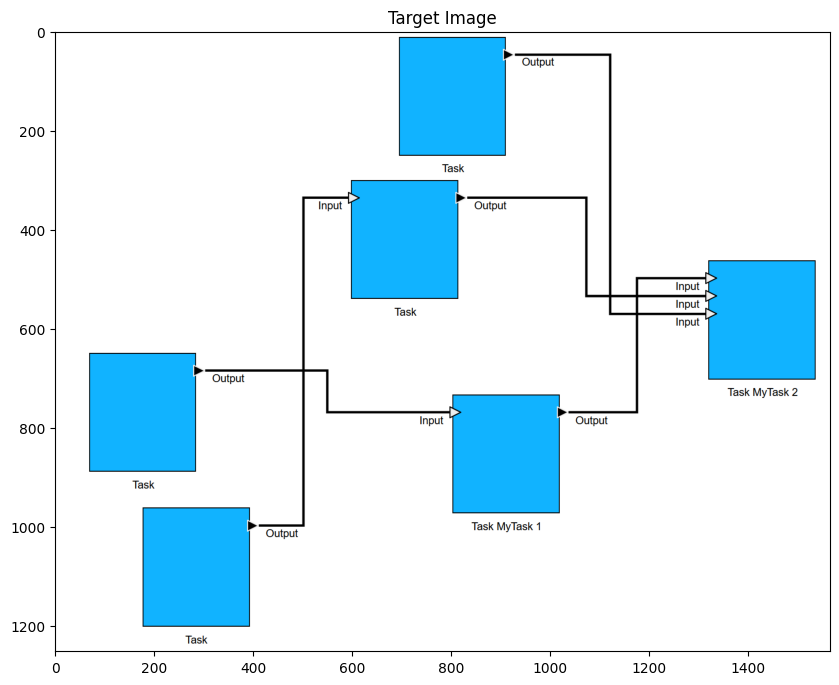

In [76]:
# Draw target image image
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
ax.set_title('Target Image')
plt.show()

## Grayscale
Currently, only grayscale is used, not thresholded

In [77]:
# Convert to grayscale
target_gray = cv2.cvtColor(target_img, cv2.COLOR_BGR2GRAY)

# Threshold the template image
_, target_thresh = cv2.threshold(target_gray, 245, 255, cv2.THRESH_BINARY_INV)

#### Visualize Grayscale

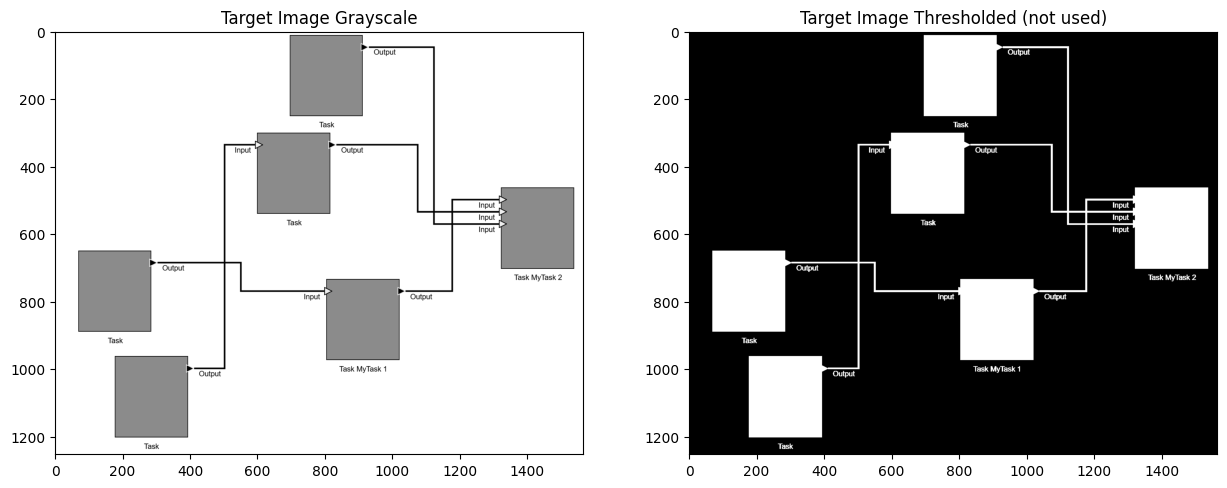

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(target_gray, cmap='gray')
ax[0].set_title('Target Image Grayscale')
ax[1].imshow(target_thresh, cmap='gray')
ax[1].set_title('Target Image Thresholded (not used)')
plt.show()

## Tesseract OCR
#### General Configuration
Good overview on page segmentation modes [Py image search](https://pyimagesearch.com/2021/11/15/tesseract-page-segmentation-modes-psms-explained-how-to-improve-your-ocr-accuracy/)

In [79]:
# Configuration strings for pytesseract
config_psm = '--psm 11'
config_oem = '--oem 3'  # Default is 3 for both LSTM and legacy engine
# config_chars = '-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789!@#$%^&*()_+=-[]{}|;:<>/? '
# config_chars = '-c tessedit_char_blacklist=T‘O'
# print(config_chars)

# Combine the configurations
custom_config = f'{config_psm} {config_oem}'
# custom_config = f'{config_psm} {config_oem} {config_chars}'

# 6 works, but is made for single uniform block of text
# 11 works 99%, made for sparse text

#### Image to Text (Debug only)
Actual output happens in Image to Data

In [80]:
text = pytesseract.image_to_string(target_gray, config=custom_config)# Replace newlines with spaces to make it a single line
formatted_text = text.replace("\n\n", " | ")
print(formatted_text)

Output | Task | Input | Output | [reat g | Task | on | Input | Output | Task MyTask 2 | Input | Output | Task | Task MyTask 1 | Output | Task



## Image to Data
This is only for testing if rotated text can also be read

In [81]:
# Rotate the image by 90 degrees
# rotated_image = rotate(target_gray, 90)

data = pytesseract.image_to_data(target_gray, output_type=Output.DICT, config=custom_config)
# data_rotated = pytesseract.image_to_data(rotated_image, output_type=Output.DICT, config=custom_config)

# draw the data as a nice panda dataframe
pd.set_option('display.width', 200)  # None should be not limit, but for some reason defaults to 80. So manually set high value. 
pd.set_option('display.max_rows', None)  # Don't truncate rows, Jupyter notebook will handle this anyways

df = pd.DataFrame(data)
# df_rotated = pd.DataFrame(data_rotated)

# # Adjust the coordinates of the bounding boxes from the rotated image
# height, width = target_gray.shape[:2]
# df_rotated['left'], df_rotated['top'] = df_rotated['top'], width - df_rotated['left'] - df_rotated['width']
# df_rotated['width'], df_rotated['height'] = df_rotated['height'], df_rotated['width']

# combined_df = pd.concat([df, df_rotated], ignore_index=True)
print(df)

    level  page_num  block_num  par_num  line_num  word_num  left   top  width  height  conf     text
0       1         1          0        0         0         0     0     0   1566    1252    -1         
1       2         1          1        0         0         0   944    54     65      20    -1         
2       3         1          1        1         0         0   944    54     65      20    -1         
3       4         1          1        1         1         0   944    54     65      20    -1         
4       5         1          1        1         1         1   944    54     65      20    67  ‘Output
5       2         1          2        0         0         0   782   269     45      16    -1         
6       3         1          2        1         0         0   782   269     45      16    -1         
7       4         1          2        1         1         0   782   269     45      16    -1         
8       5         1          2        1         1         1   782   269     45    

#### Visualize OCR Result

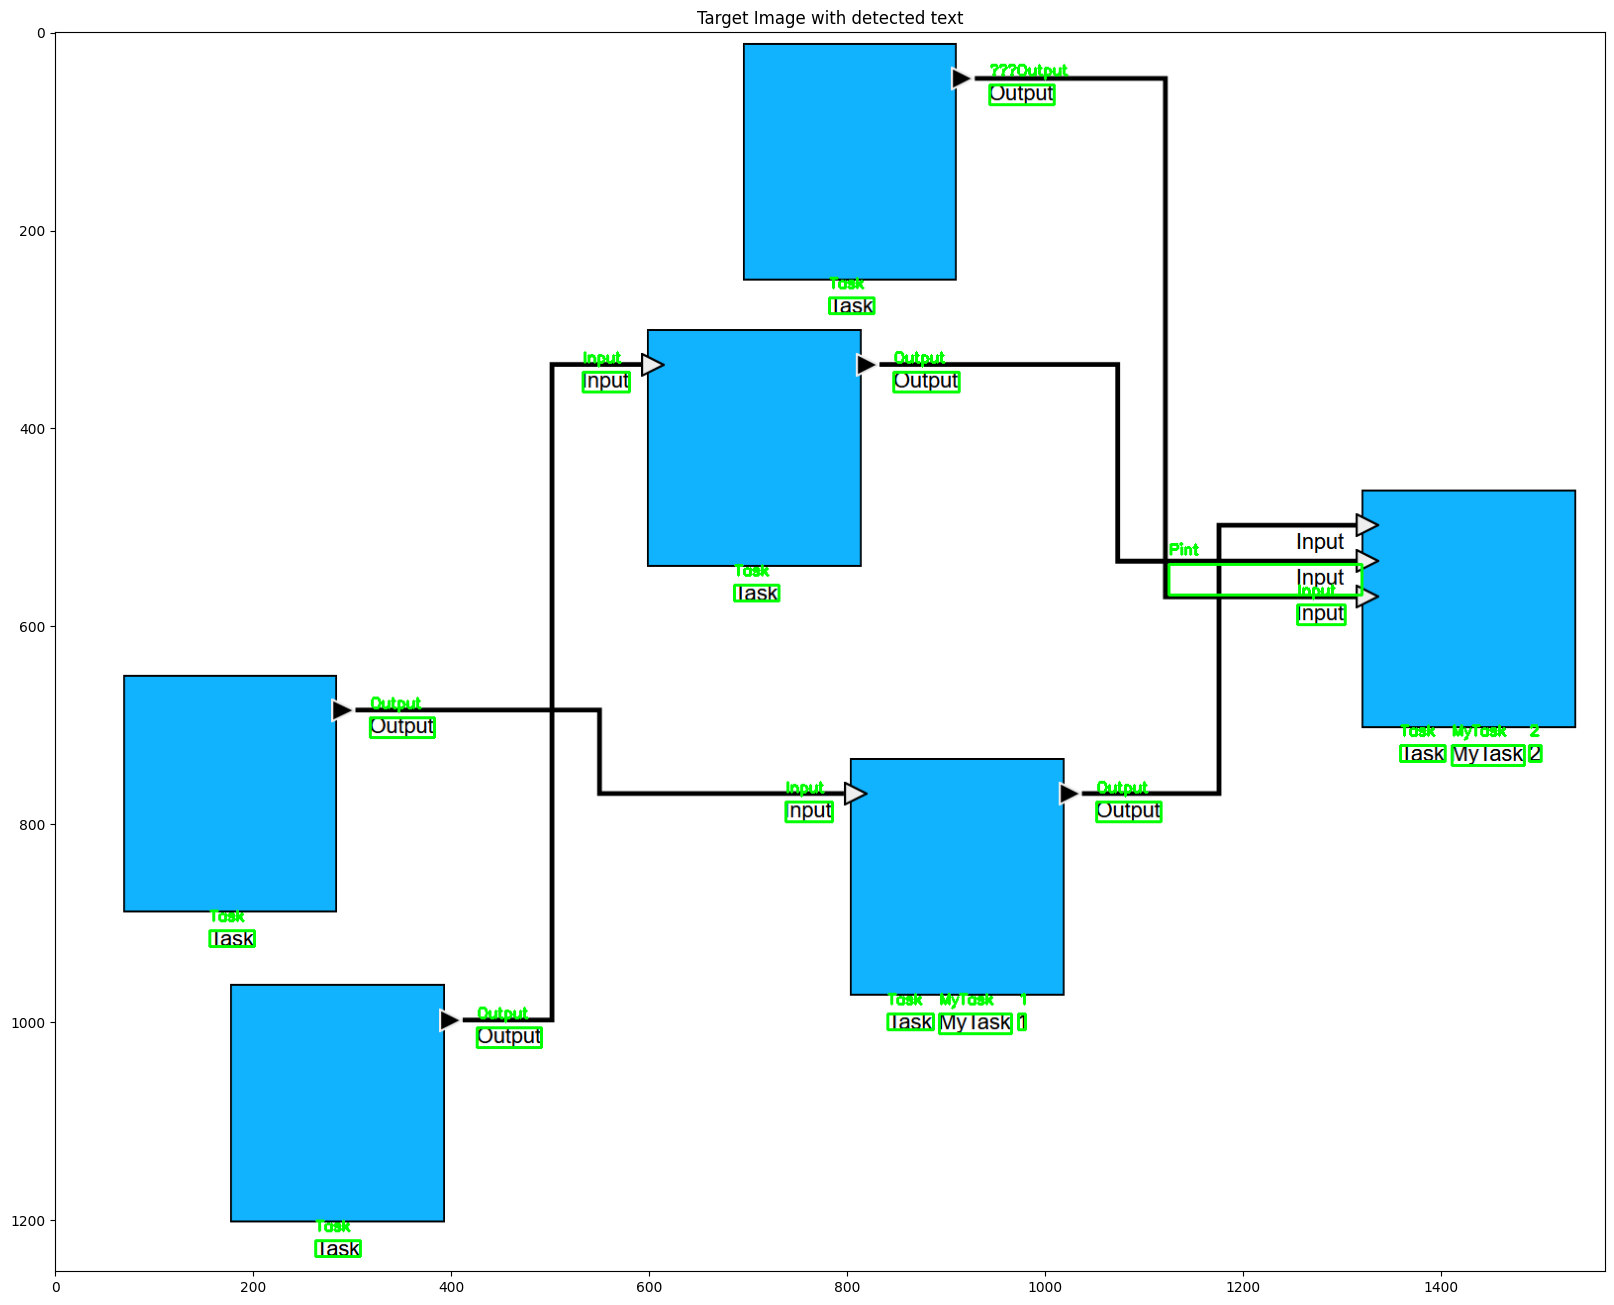

In [82]:
# Draw the bounding boxes
plot_img = target_img.copy()
n_boxes = len(data['text'])
for i in range(n_boxes):
    if int(data['conf'][i]) > 0: # only text has a confidence value, so basically filters for text
        (x, y, w, h) = (data['left'][i], data['top'][i], data['width'][i], data['height'][i])
        plot_img = cv2.rectangle(plot_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # put text
        plot_img = cv2.putText(plot_img, data['text'][i], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Draw target image image
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.imshow(cv2.cvtColor(plot_img, cv2.COLOR_BGR2RGB))
ax.set_title('Target Image with detected text')
plt.show()

# doc for pandas options
# pd.describe_option('display')


#### Histogram of confidence

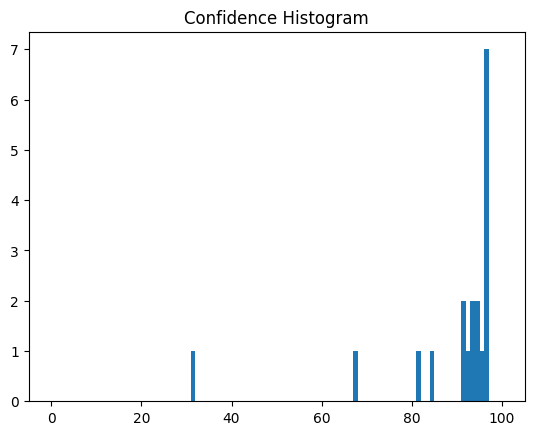

In [83]:
# plot the confidences in a histogram
plt.hist(df['conf'], bins=100, range=(0, 100))
plt.title('Confidence Histogram')
plt.show()

## Processing
From raw word boxes to someething useful

#### Merge single Words into Text Labels
Group neighboring words together to labels. Keep confidence for further processing. 

* expected format: 
* [1157, 295, 146, 13, 'Task Actor Locked ', 96]
* left, top, widht, height, text, confidence

In [84]:
# merge single words to blocks which represent a text label
text_boxes = []
for textbox in range(len(data['text'])):  # iterate over the data
    level = data['level'][textbox]  # get the level of the current data
    if level == 2:  # if the level is 2, then it is a block. All our labels are words grouped in a block. (and line and paragraph)
        # store the bounding box, prepare an empty text string, untouched confidence is 100
        # format: left, top, width, height, text, confidence
        text_boxes.append( [data['left'][textbox], data['top'][textbox], data['width'][textbox], data['height'][textbox], "", 100] )
    elif level == 5:
        # add the text to the last block, position 4 is text
        text_boxes[-1][4] = text_boxes[-1][4] + data['text'][textbox] + " "
        # confidence is worst of old and new, position 5 is confidence
        text_boxes[-1][5] = min(text_boxes[-1][5], data['conf'][textbox])

print(text_boxes)

[[944, 54, 65, 20, '‘Output ', 67], [782, 269, 45, 16, 'Task ', 96], [533, 344, 47, 20, 'Input ', 96], [847, 344, 66, 20, 'Output ', 94], [1125, 538, 195, 31, 'Pint ', 31], [686, 559, 45, 16, 'Task ', 96], [1255, 579, 48, 20, 'Input ', 94], [318, 693, 65, 20, 'Output ', 84], [1359, 721, 142, 20, 'Task MyTask 2 ', 91], [738, 778, 47, 20, 'Input ', 96], [1052, 778, 65, 20, 'Output ', 81], [156, 908, 45, 16, 'Task ', 96], [841, 992, 139, 20, 'Task MyTask 1 ', 92], [426, 1006, 65, 20, 'Output ', 91], [263, 1221, 45, 16, 'Task ', 95]]


#### Remove trailing space

In [85]:
# remove the trailing space from the text, e.g. 'Output '
for textbox in text_boxes:
    textbox[4] = textbox[4].strip()
print(text_boxes)

[[944, 54, 65, 20, '‘Output', 67], [782, 269, 45, 16, 'Task', 96], [533, 344, 47, 20, 'Input', 96], [847, 344, 66, 20, 'Output', 94], [1125, 538, 195, 31, 'Pint', 31], [686, 559, 45, 16, 'Task', 96], [1255, 579, 48, 20, 'Input', 94], [318, 693, 65, 20, 'Output', 84], [1359, 721, 142, 20, 'Task MyTask 2', 91], [738, 778, 47, 20, 'Input', 96], [1052, 778, 65, 20, 'Output', 81], [156, 908, 45, 16, 'Task', 96], [841, 992, 139, 20, 'Task MyTask 1', 92], [426, 1006, 65, 20, 'Output', 91], [263, 1221, 45, 16, 'Task', 95]]


#### Remove too big (height) text
Typically, this is blocks detected as text. So filter such that text labels have a limited height. Actually this filtering might make sense earlier? 

In [86]:
MAX_HEIGHT = 100
# remove text boxes which are too big
original_number_of_text_boxes = len(text_boxes)
text_boxes = [textbox for textbox in text_boxes if textbox[3] < MAX_HEIGHT]
print(f"Removed {original_number_of_text_boxes - len(text_boxes)} text boxes because they were too big. ") # debug message
print(text_boxes)

Removed 0 text boxes because they were too big. 
[[944, 54, 65, 20, '‘Output', 67], [782, 269, 45, 16, 'Task', 96], [533, 344, 47, 20, 'Input', 96], [847, 344, 66, 20, 'Output', 94], [1125, 538, 195, 31, 'Pint', 31], [686, 559, 45, 16, 'Task', 96], [1255, 579, 48, 20, 'Input', 94], [318, 693, 65, 20, 'Output', 84], [1359, 721, 142, 20, 'Task MyTask 2', 91], [738, 778, 47, 20, 'Input', 96], [1052, 778, 65, 20, 'Output', 81], [156, 908, 45, 16, 'Task', 96], [841, 992, 139, 20, 'Task MyTask 1', 92], [426, 1006, 65, 20, 'Output', 91], [263, 1221, 45, 16, 'Task', 95]]


#### Remove single non-text character blocks

In [87]:
forbidden_chars = ['<','.','>',',','/',';',':','\'','"','[',']','{','}','|','\\','`','~','!','^','(',')','_','-','+','=']
# remove text boxes which have as text only a forbidden character
original_number_of_text_boxes = len(text_boxes)
text_boxes = [textbox for textbox in text_boxes if textbox[4] not in forbidden_chars]
print(f"Removed {original_number_of_text_boxes - len(text_boxes)} text boxes because they were forbidden characters. ") # debug message
print(text_boxes)

Removed 0 text boxes because they were forbidden characters. 
[[944, 54, 65, 20, '‘Output', 67], [782, 269, 45, 16, 'Task', 96], [533, 344, 47, 20, 'Input', 96], [847, 344, 66, 20, 'Output', 94], [1125, 538, 195, 31, 'Pint', 31], [686, 559, 45, 16, 'Task', 96], [1255, 579, 48, 20, 'Input', 94], [318, 693, 65, 20, 'Output', 84], [1359, 721, 142, 20, 'Task MyTask 2', 91], [738, 778, 47, 20, 'Input', 96], [1052, 778, 65, 20, 'Output', 81], [156, 908, 45, 16, 'Task', 96], [841, 992, 139, 20, 'Task MyTask 1', 92], [426, 1006, 65, 20, 'Output', 91], [263, 1221, 45, 16, 'Task', 95]]


#### Write out worst confidence
Might be good for debugging.

In [88]:
# get the worst confidence
worst_confidence = min([textbox[5] for textbox in text_boxes])
print(f"Tesseract OCR: worst text remaining detection confidence is {worst_confidence}.") # info message

Tesseract OCR: worst text remaining detection confidence is 31.


#### Visualize Remaining Text Blocks = Labels

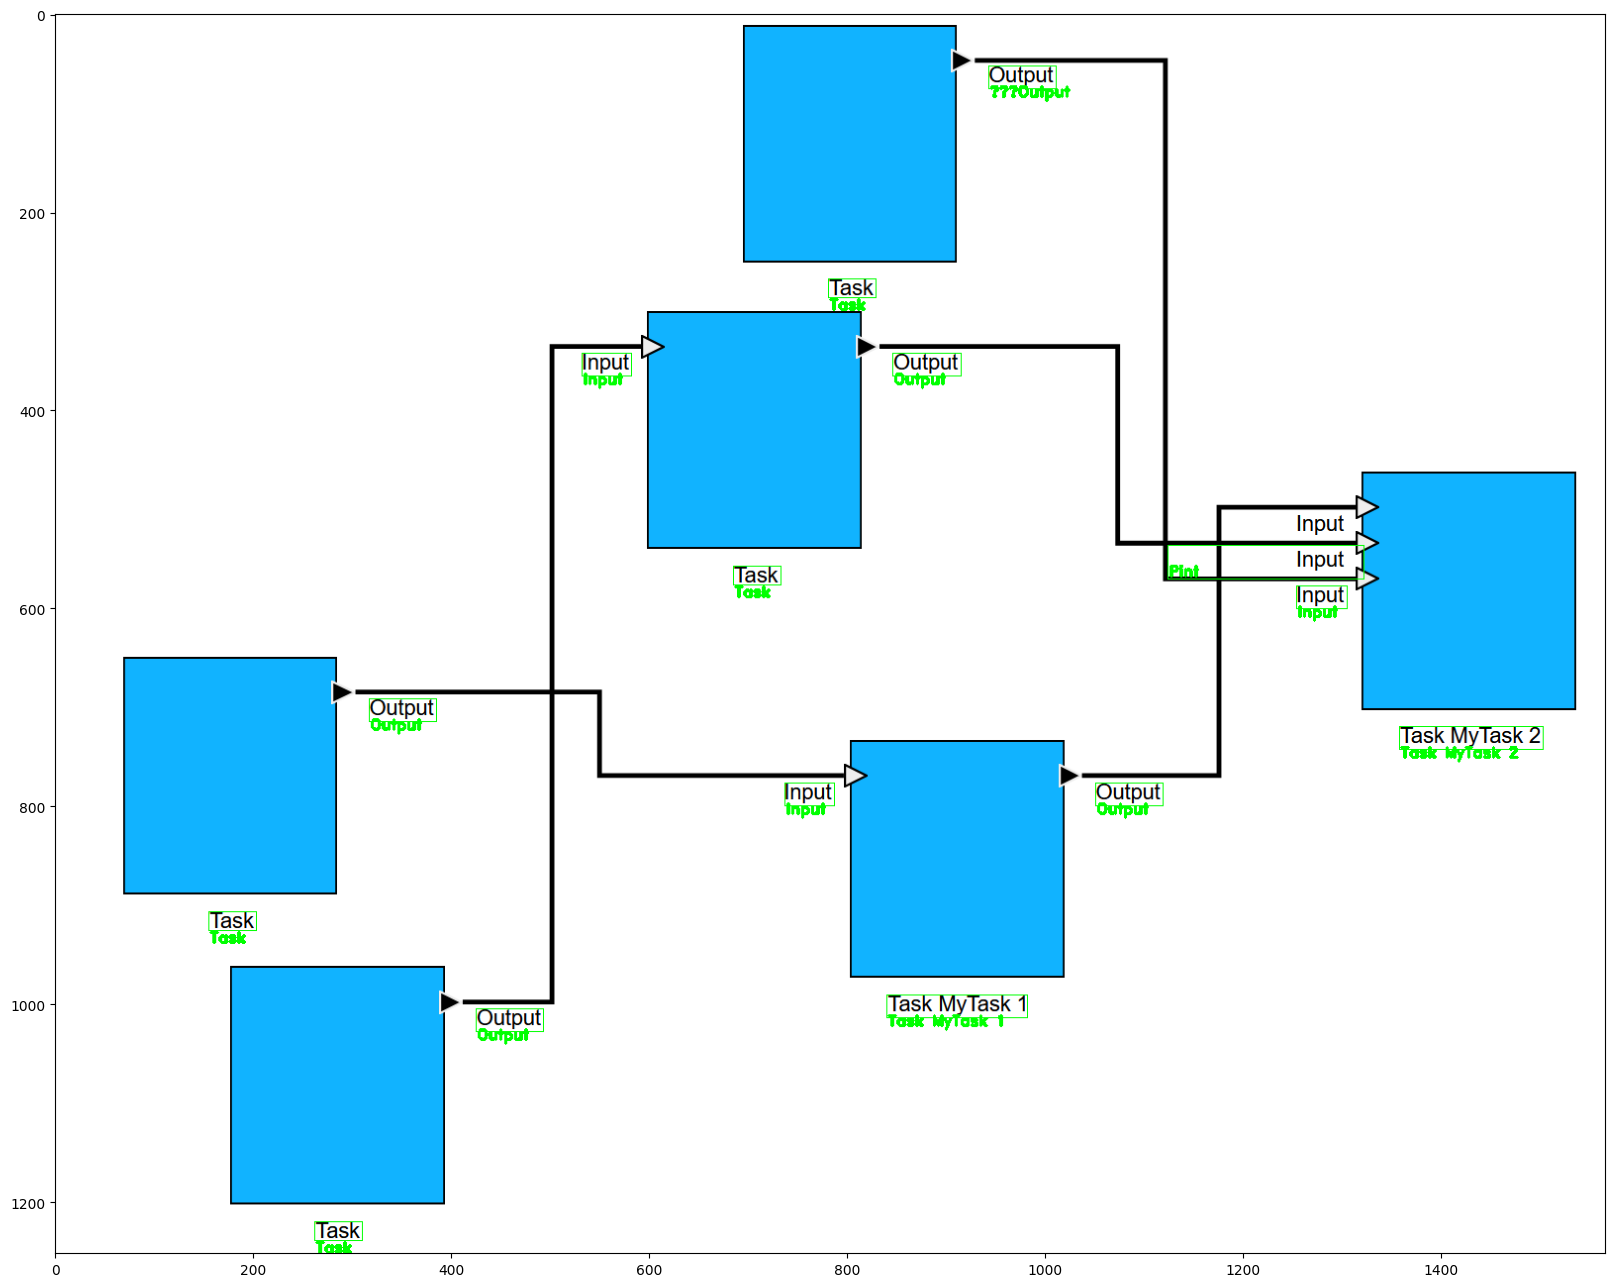

In [89]:
# Draw the merged bounding boxes on the image
img_bbox_blocks = target_img.copy()
for (x, y, w, h, text, conf) in text_boxes:
    cv2.rectangle(img_bbox_blocks, (x-1, y-1), (x + w + 2, y + h + 2), (0, 255, 0), 1)
    cv2.putText(img_bbox_blocks, text, (x, y + 30), cv2.FONT_HERSHEY_DUPLEX , 0.5, (0, 255, 0), 2)

# Plot the merged bounding boxes
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.imshow(cv2.cvtColor(img_bbox_blocks, cv2.COLOR_BGR2RGB))

plt.show()

# Appendix, currently not relevant
Here only for historic reasons 
* .
*
*
*
*
*
*
*
*
*
*
*

### Filter

{'block_num': [1, 2, 3, 4, 6, 7, 8, 9, 9, 9, 10, 11, 12, 13, 13, 13, 14, 15],
 'conf': [67,
          96,
          96,
          94,
          96,
          94,
          84,
          93,
          91,
          96,
          96,
          81,
          96,
          93,
          92,
          96,
          91,
          95],
 'height': [20,
            16,
            20,
            20,
            16,
            20,
            20,
            16,
            20,
            16,
            20,
            20,
            16,
            16,
            20,
            16,
            20,
            16],
 'left': [944,
          782,
          533,
          847,
          686,
          1255,
          318,
          1359,
          1411,
          1489,
          738,
          1052,
          156,
          841,
          893,
          973,
          426,
          263],
 'level': [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
 'line_num': [1, 1, 1, 1, 1, 1, 1, 1, 

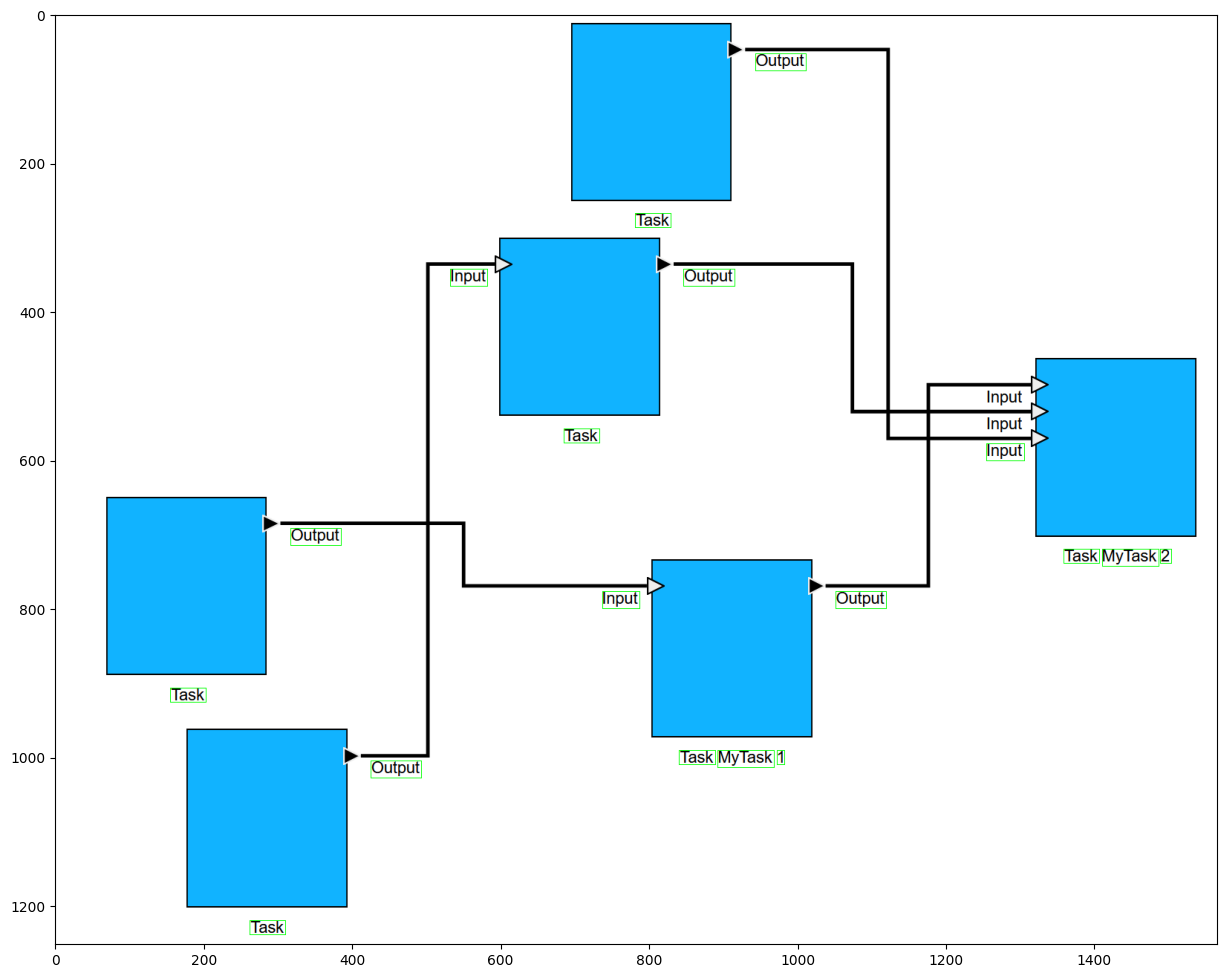

In [90]:
# Filter the detected text and their bounding boxes for a confidence threshold
confidence_threshold = 60
filtered_data = {key: [value[i] for i in range(len(data['conf'])) if data['conf'][i] > confidence_threshold] for key, value in data.items()}
pprint.pprint(filtered_data)

# Draw the bounding boxes on the image
bbox_img = target_img.copy()
for textbox in range(len(filtered_data['text'])):
    (x, y, w, h) = (filtered_data['left'][textbox], filtered_data['top'][textbox], filtered_data['width'][textbox], filtered_data['height'][textbox])
    cv2.rectangle(bbox_img, (x-1, y-1), (x + w + 2, y + h + 2), (0, 255, 0), 1) # bounding boxes 1 pixel larger than the detected text
    # print(f"Detected text: {filtered_data['text'][i]} (Confidence: {filtered_data['conf'][i]}%)")

# Plot the bounding boxes
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(cv2.cvtColor(bbox_img, cv2.COLOR_BGR2RGB))
plt.show()


### Merge Word Boxes to String Boxes

[[944, 54, 65, 20, '‘Output'], [782, 269, 45, 16, 'Task'], [533, 344, 47, 20, 'Input'], [847, 344, 66, 20, 'Output'], [686, 559, 45, 16, 'Task'], [1255, 579, 48, 20, 'Input'], [318, 693, 65, 20, 'Output'], [1359, 721, 142, 20, 'Task MyTask 2'], [738, 778, 47, 20, 'Input'], [1052, 778, 65, 20, 'Output'], [156, 908, 45, 16, 'Task'], [841, 992, 139, 20, 'Task MyTask 1'], [426, 1006, 65, 20, 'Output'], [263, 1221, 45, 16, 'Task']]


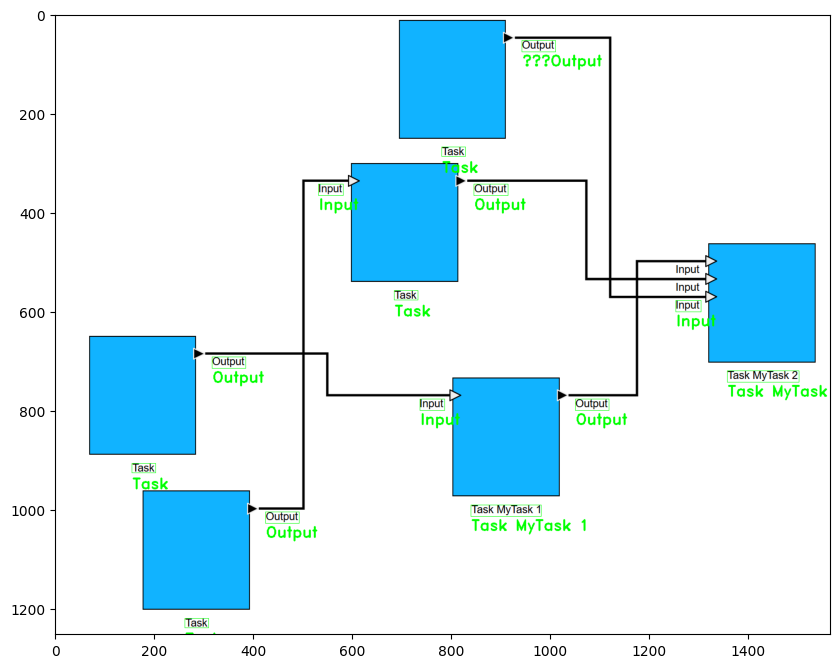

In [91]:
def merge_adjacent_boxes(data, horizontal_threshold=7, vertical_threshold=1):
    """
    Merge bounding boxes that are adjacent and aligned vertically within specified thresholds.

    Parameters:
    - data: Dictionary containing 'left', 'top', 'width', 'height', and 'text' of bounding boxes.
    - horizontal_threshold: Maximum horizontal gap between boxes to consider them adjacent.
    - vertical_threshold: Maximum vertical difference to consider boxes on the same line.

    Returns:
    - List of merged boxes with format [x, y, w, h, text].
    """
    merged_boxes = []

    for i, text in enumerate(data['text']):
        x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
        # print(f"Processing box {i} with text: {text}")
        # print(f"Box {i} coordinates: ({x}, {y}, {w}, {h})")

        # Attempt to merge with the last box in merged_boxes if not empty
        if merged_boxes:
            last_box = merged_boxes[-1]
            last_box_right_edge = last_box[0] + last_box[2]
            last_box_bottom_edge = last_box[1] + last_box[3]

            # Check if current box is adjacent and vertically aligned with the last box
            if (x <= last_box_right_edge + horizontal_threshold and
                    abs(y - last_box[1]) <= vertical_threshold):
                # Merge current box with the last box
                new_right_edge = max(last_box_right_edge, x + w)
                new_bottom_edge = max(last_box_bottom_edge, y + h)
                last_box[2] = new_right_edge - last_box[0]  # Update width
                last_box[3] = new_bottom_edge - last_box[1]  # Update height
                last_box[4] += " " + text  # Concatenate text
            else:
                # Add as a new box if not adjacent/aligned
                merged_boxes.append([x, y, w, h, text])
        else:
            # Add the first box
            merged_boxes.append([x, y, w, h, text])

    return merged_boxes

merged_boxes = merge_adjacent_boxes(filtered_data)
print(merged_boxes)

# Draw the merged bounding boxes on the image
img_bbox_merge = target_img.copy()
for (x, y, w, h, text) in merged_boxes:
    cv2.rectangle(img_bbox_merge, (x-1, y-1), (x + w + 2, y + h + 2), (0, 255, 0), 1)
    cv2.putText(img_bbox_merge, text, (x, y + 50), cv2.FONT_HERSHEY_DUPLEX , 1, (0, 255, 0), 2)

# Plot the merged bounding boxes
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(cv2.cvtColor(img_bbox_merge, cv2.COLOR_BGR2RGB))
plt.show()
